In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML100k'

In [2]:
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as sklearn
import datetime as dt 
import seaborn as sns
import torch as torch

In [4]:
dfratings=pd.read_csv(f'{DATAPATH}/ratings.csv')

In [5]:
dfmovies=pd.read_csv (f'{DATAPATH}/movies.csv')

In [6]:
dflinks=pd.read_csv(f'{DATAPATH}/links.csv')

In [7]:
dftags=pd.read_csv(f'{DATAPATH}/tags.csv')

In [8]:
dfratings['timestamp']=pd.to_datetime(dfratings['timestamp'],unit='s')

In [9]:
print(dfratings.shape)
dfratings=pd.merge(dfratings,dfmovies,on='movieId',how='left')
print(dfratings.shape)

(100836, 4)
(100836, 6)


In [10]:
print(dfratings.shape)
dfratings=pd.merge(dfratings,dflinks,on='movieId',how='left')
print(dfratings.shape)

(100836, 6)
(100836, 8)


In [11]:
dftags=dftags.groupby(['userId','movieId'],as_index=False)['tag'].agg(lambda x: ' '.join(x.values.astype(str)))

In [12]:
print(dfratings.shape)
dfratings=pd.merge(dfratings, dftags,on=['userId','movieId'],how='left')
print(dfratings.shape)

(100836, 8)
(100836, 9)


In [13]:
dfratings.rename({'movieId':'itemId'},axis=1,inplace=True)

In [14]:
dfratings.head()

,userId,itemId,rating,timestamp,title,genres,imdbId,tmdbId,tag
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,NaN
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,113277,949.0,NaN
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,NaN
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0,NaN


### CROSS-VALIDATION - SIMULATE COLD START

In [15]:
# normal method is to keep the first x% of the ratings for each user as training and the rest as validation
# we want to simulate cold start by applying above only to users who were acquired in older years except last 2 years

In [16]:
dfratings.sort_values(by=['userId','timestamp'],inplace=True)

In [17]:
dfratings['seqNum']=dfratings.groupby('userId').cumcount()+1

In [18]:
dfratings['year']=dfratings['timestamp'].dt.year

In [19]:
dfacqyear=dfratings.loc[dfratings['seqNum']==1,['userId','year']]

In [20]:
dfratings=pd.merge(dfratings,dfacqyear,on='userId',how="left",suffixes=("","_acq"))

In [21]:
dfratings['year_acq'].value_counts().sort_index()

1996     6207
1997     1933
1998      375
1999     3803
2000    15050
2001     2642
2002     4065
2003     3226
2004     3813
2005     4769
2006     4135
2007     7371
2008     3313
2009     4188
2010     1234
2011     1719
2012     4446
2013     1656
2014      563
2015     6707
2016     7448
2017     7629
2018     4544
Name: year_acq, dtype: int64

### Exploratory Analysis Chart

In [24]:
dfratings.head()

,userId,itemId,rating,timestamp,title,genres,imdbId,tmdbId,tag,seqNum,year,year_acq
0,1,804,4.0,2000-07-30 18:08:19,She's the One (1996),Comedy|Romance,117628,11363.0,NaN,1,2000,2000
1,1,1210,5.0,2000-07-30 18:08:19,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,86190,1892.0,NaN,2,2000,2000
2,1,2018,5.0,2000-07-30 18:08:43,Bambi (1942),Animation|Children|Drama,34492,3170.0,NaN,3,2000,2000
3,1,2628,4.0,2000-07-30 18:08:43,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,120915,1893.0,NaN,4,2000,2000
4,1,2826,4.0,2000-07-30 18:08:43,"13th Warrior, The (1999)",Action|Adventure|Fantasy,120657,1911.0,NaN,5,2000,2000


In [25]:
# How are the ratings distributed by year
ratings_by_year=dfratings['year'].value_counts().sort_index()
ratings_by_year=pd.DataFrame(ratings_by_year)
ratings_by_year.reset_index(inplace=True)
ratings_by_year.columns=['Year','numratings']
ratings_by_year['Year']=ratings_by_year['Year'].astype(str)

Text(0.5, 1.0, 'Ratings by Year')

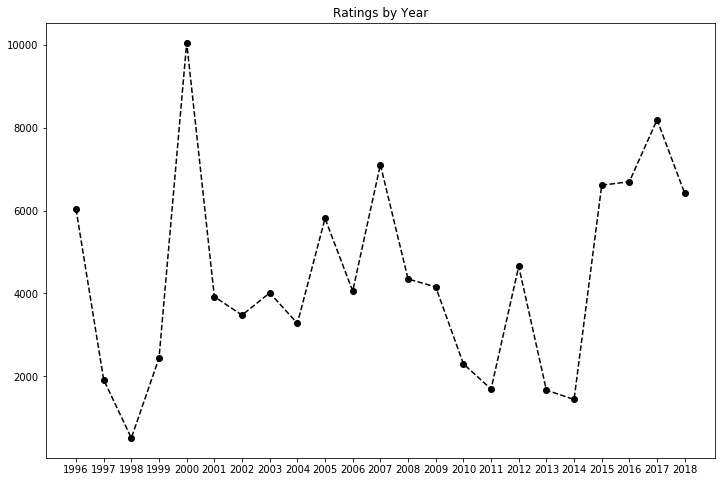

In [39]:
figure=plt.figure(figsize=(12,8))
plt.plot (ratings_by_year['Year'],ratings_by_year['numratings'],'o--', color='black')
plt.title('Ratings by Year')

In [32]:
temp=dfratings.loc[dfratings['seqNum']==1].year.value_counts().sort_index()

In [33]:
temp=pd.DataFrame(temp)

In [34]:
temp.reset_index(inplace=True)
temp.columns=['year','new_Users']

Text(0, 0.5, 'New Users')

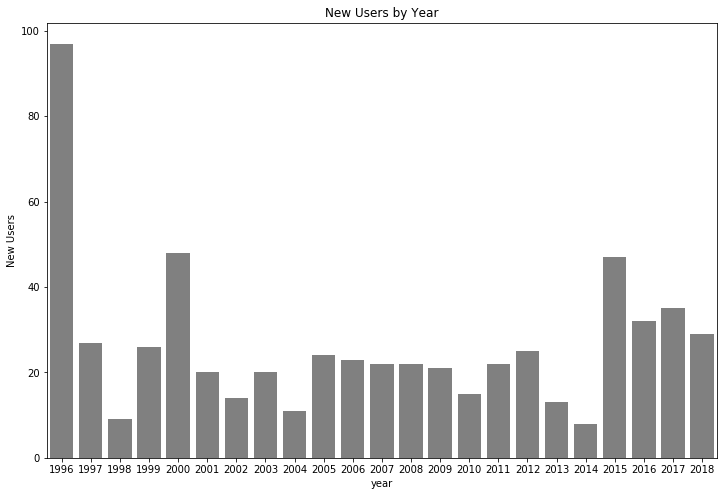

In [37]:
figure=plt.figure(figsize=(12,8))
ax=sns.barplot(x=temp['year'],y=temp['new_Users'],color='grey')
ax.set_title('New Users by Year')
ax.set_ylabel ('New Users')

In [40]:
dfratings['month']=dfratings['timestamp'].dt.month

In [41]:
pd.crosstab(index=dfratings['month'],columns=dfratings['year'])

year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,,,,,,,,,,,
1,0,250,57,4,297,1107,66,501,139,1172,...,504,138,153,511,150,57,375,344,193,950
2,0,323,1,32,303,69,148,156,160,445,...,494,253,106,231,44,358,216,576,420,1169
3,58,398,130,7,779,37,78,842,216,1041,...,1085,345,85,623,57,13,89,834,549,971
4,165,219,0,0,622,160,635,45,111,966,...,135,321,23,438,196,7,207,1755,923,230
5,832,303,32,36,157,302,158,608,544,879,...,284,87,248,148,263,37,682,297,2397,951
6,883,84,43,3,1180,177,84,872,213,411,...,80,358,180,203,48,84,723,103,1910,419
7,489,70,113,4,1081,577,165,275,220,278,...,159,70,125,394,18,78,910,966,170,293
8,1010,0,119,3,2319,244,548,104,203,173,...,115,58,90,133,380,89,424,62,221,831
9,384,236,0,1,298,188,671,221,874,239,...,210,81,286,897,265,82,476,355,424,604


In [22]:
dfsimulate=dfratings.loc[dfratings['year_acq']>2017]
dfnormal=dfratings.loc[dfratings['year_acq']<=2017]

In [23]:
postusers=dfsimulate['userId'].unique()

In [24]:
postusers=np.random.permutation(postusers)

In [25]:
trainfrac=0.9

In [26]:
postusers_train=postusers[:np.int(np.round(len(postusers)*trainfrac))]

In [27]:
dfsimulate['flag_train']=dfsimulate['userId'].isin(postusers_train)

/home/kirana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
dfsimulate['flag_train'].value_counts()

True     4463
False      81
Name: flag_train, dtype: int64

In [29]:
dfseq=dfnormal.groupby('userId',as_index=False)['seqNum'].max()

In [30]:
dfseq.head()

,userId,seqNum
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [31]:
dfseq.columns=['userId','maxSeqNum']

In [32]:
dfnormal=pd.merge(dfnormal,dfseq,on='userId',how='left')

In [33]:
dfnormal['flag_train']=np.where(dfnormal['seqNum']<np.round(trainfrac*dfnormal['maxSeqNum']).astype(np.int),1,0)

In [34]:
dfnormal['flag_train'].value_counts()

1    86080
0    10212
Name: flag_train, dtype: int64

In [35]:
trainfrac

0.9

In [41]:
dftrain=pd.concat([dfnormal.loc[dfnormal['flag_train']==1],dfsimulate.loc[dfsimulate['flag_train']==1]],axis=0,sort=True)

In [42]:
dfvalid=pd.concat([dfnormal.loc[dfnormal['flag_train']!=1],dfsimulate.loc[dfsimulate['flag_train']!=1]],axis=0,sort=True)

In [43]:
dftrain.shape, dfvalid.shape

((90543, 14), (10293, 14))

In [44]:
dftrain.dtypes

flag_train             int64
genres                object
imdbId                 int64
itemId                 int64
maxSeqNum            float64
rating               float64
seqNum                 int64
tag                   object
timestamp     datetime64[ns]
title                 object
tmdbId               float64
userId                 int64
year                   int64
year_acq               int64
dtype: object

In [45]:
import pickle

In [46]:
dfvalid['flag_train'].value_counts()

0    10293
Name: flag_train, dtype: int64

In [47]:
pickle.dump([dftrain,dfvalid],open(f'{DATAPATH}/df.pkl','wb'))